In [1]:
Verbose = False
if Verbose:
    def vprint(*args, **kwargs): print(*args, **kwargs, flush=True)
else: # do-nothing function
    def vprint(*args, **kwargs): None

In [2]:
import torch
import numpy as np
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 100)

import matplotlib.pyplot as plt

from IPython.display import display

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Load the sentences

In [3]:
df_train = pd.read_csv("./sick_train/SICK_train.txt", sep="\t")
df_train = df_train.drop(['relatedness_score'], axis=1)

df_dev = pd.read_csv("./sick_trial/SICK_trial.txt", sep="\t")
df_dev = df_dev.drop(['relatedness_score'], axis=1)

df_test = pd.read_csv("./sick_test/SICK_test.txt", sep="\t")
df_test = df_test.drop(['relatedness_score'], axis=1)

In [4]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [5]:
from gensim import corpora

In [6]:
class SickDataset(Dataset):
    endOfSentence   = '</s>'
    startOfSentence = '<s>'
    separator2Sentences = '<sep>'
    
    text_label = ["NEUTRAL", "ENTAILMENT", "CONTRADICTION"]
    
    tokens = [startOfSentence, separator2Sentences, endOfSentence]
    
    def join_sentence(self, row):
        """
        Create a new sentence (<s> + s_A + <sep> + s_B + </s>)
        """
        sentence_a = row['sentence_A'].split(" ")
        sentence_b = row['sentence_B'].split(" ")
        return np.concatenate((
            [self.startOfSentence],
            sentence_a,
            [self.separator2Sentences],
            sentence_b,
            [self.endOfSentence]
        ))
    
    def series_text_2_labelID(self, series, keep_n=1000):
        """
        Convert text Label into label id
        """
        reverse_dict = {v: k for k, v in  dict(enumerate(self.text_label)).items()}
        return series.map(reverse_dict)
    
    def series_2_dict(self, series, keep_n):
        """
        Convert document (a list of words) into a list of indexes
        AND apply some filter on the documents
        """
        dictionary = corpora.Dictionary(series)
        dictionary.filter_extremes(
            no_below=1,
            no_above=1,
            keep_n=keep_n,
            keep_tokens=self.tokens)
        return dictionary
    
    
    def __init__(self, df, vocabulary_size, dic=None):
        self.vocabulary_size = vocabulary_size
        
        # Label text as ids
        df["entailment_id"] = self.series_text_2_labelID(df['entailment_judgment'])
        
        # Add <s>,</s>,<sep> tokens to the vocabulary
        df['sentence_AB'] = df.apply(self.join_sentence, axis=1)
        
        # check if the dictionary is given
        if dic is None:
            # Create the Dictionary
            self.dictionary = self.series_2_dict(df['sentence_AB'], vocabulary_size)
        else:
            self.dictionary = dic
        
        # sentence of words -> array of idx
        # Adds unknown to the voc (idx = len(dictionary)), len(dictionary) = vocabulary_size
        # Adds one to each (no tokens at 0, even <unk>)
        # 0 is for the padding when using mini-batch
        df["word_idx"] = df["sentence_AB"].apply(
            lambda word: np.array(self.dictionary.doc2idx(word, unknown_word_index=vocabulary_size)) + 1
        )
        
        self.df = df

        # compute a sorted occurence dictionary on the whole corpus
        occ_dict = {}
        for serie in df['sentence_AB']:
            unique, counts = np.unique(serie, return_counts=True)
            tmp_dict = dict(zip(unique, counts))
            
            for key, value in tmp_dict.items():
                if key in occ_dict:
                    occ_dict[key] = occ_dict[key] + tmp_dict[key]
                else:
                    occ_dict[key] = value
        
        self.occ_dict_list = [[key, value] for key, value in occ_dict.items()]
        self.occ_dict_list.sort(key=lambda x: x[1], reverse=True)
        
    def getSortedOccDictList(self):
        return self.occ_dict_list
    
    def plotVocabularyCoverage(self):
        occdict_list = self.occ_dict_list
        
        total = 0
        y = []
        for i, value in enumerate(occdict_list):
            total += value[1]
            y.append(total)
            if (i == self.vocabulary_size):
                current_voc_cov = total

        current_voc_cov = current_voc_cov*100.0/total
        
        y = [tmp*100.0/total for tmp in y]

        x = np.linspace(0, len(occdict_list), len(occdict_list))

        # Show graph
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 20
        fig_size[1] = 9
        plt.rcParams["figure.figsize"] = fig_size

        legend, = plt.plot(x, y, label='Vocabulary size ')

        plt.title(('Current vocabulary size n=' + str(self.vocabulary_size) + ' coverage = ' +"{:.4}".format(current_voc_cov) + '%'),
                     fontsize=14, fontweight='bold', color='gray')
        plt.suptitle(('Vocabulary coverage'),
                     fontsize=24, fontweight='bold', color='gray')
        plt.xlabel("Size of unique vocabulary", color='gray', fontsize=14)
        plt.ylabel("Vocabulary coverage %", color='gray', fontsize=14)

        ## Plot Swagg ##
        plt.yticks(fontsize=14, rotation=0, color='gray')
        plt.xticks(fontsize=14, rotation=0, color='gray')

        # Less border
        plt.gca().xaxis.grid(True)
        plt.gca().yaxis.grid(True)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.show()
        
    def getRef(self, index):
        return self.df['sentence_AB'][index]
        
    def __getitem__(self, index):
        return (
            self.df['word_idx'][index],
            self.df['entailment_id'][index])
    
    def getDictionary(self):
        return self.dictionary
    
    def __len__(self):
        return len(self.df)

    
vocabulary_size = 1500

# Dataset

In [7]:
# Create the train dataset
sick_dataset_train = SickDataset(df_train, vocabulary_size)
sick_dataset_train.df.head()

,pair_ID,sentence_A,sentence_B,entailment_judgment,entailment_id,sentence_AB,word_idx
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,0,"[<s>, A, group, of, kids, is, playing, in, a, yard, and, an, old, man, is, standing, in, the, ba...","[2, 4, 10, 15, 13, 12, 17, 11, 5, 20, 7, 6, 16, 14, 12, 18, 11, 19, 8, 3, 4, 10, 15, 9, 11, 5, 2..."
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, A, group, of, children, is, playing, in, the, house, and, there, is, no, man, standing, in...","[2, 4, 10, 15, 21, 12, 17, 11, 19, 22, 7, 24, 12, 23, 14, 18, 11, 19, 8, 3, 4, 10, 15, 13, 12, 1..."
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,1,"[<s>, The, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, The, ...","[2, 25, 32, 9, 26, 17, 28, 7, 19, 14, 12, 30, 1501, 3, 25, 13, 26, 17, 28, 27, 5, 14, 31, 5, 29, 1]"
3,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, The, kids, are, playing, outdoors, near, a, man, with, a, smile, <sep>, A, group, of, kids...","[2, 25, 13, 26, 17, 28, 27, 5, 14, 31, 5, 29, 3, 4, 10, 15, 13, 12, 17, 11, 5, 20, 7, 6, 16, 14,..."
4,9,The young boys are playing outdoors and the man is smiling nearby,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, The, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, A, gr...","[2, 25, 32, 9, 26, 17, 28, 7, 19, 14, 12, 30, 1501, 3, 4, 10, 15, 13, 12, 17, 11, 5, 20, 7, 6, 1..."


In [8]:
# Create the dev dataset
dictionary_train = sick_dataset_train.getDictionary()

sick_dataset_dev = SickDataset(df_dev, vocabulary_size, dictionary_train)

In [9]:
# Create the test dataset
sick_dataset_test = SickDataset(df_test, vocabulary_size, dictionary_train)

In [10]:
pd.DataFrame(list(zip(sick_dataset_train.getRef(6)[-10:], sick_dataset_train[2][0]))).T

,0,1,2,3,4,5,6,7,8,9
0,the,man,in,pants,<sep>,Two,dogs,are,fighting,</s>
1,2,25,32,9,26,17,28,7,19,14


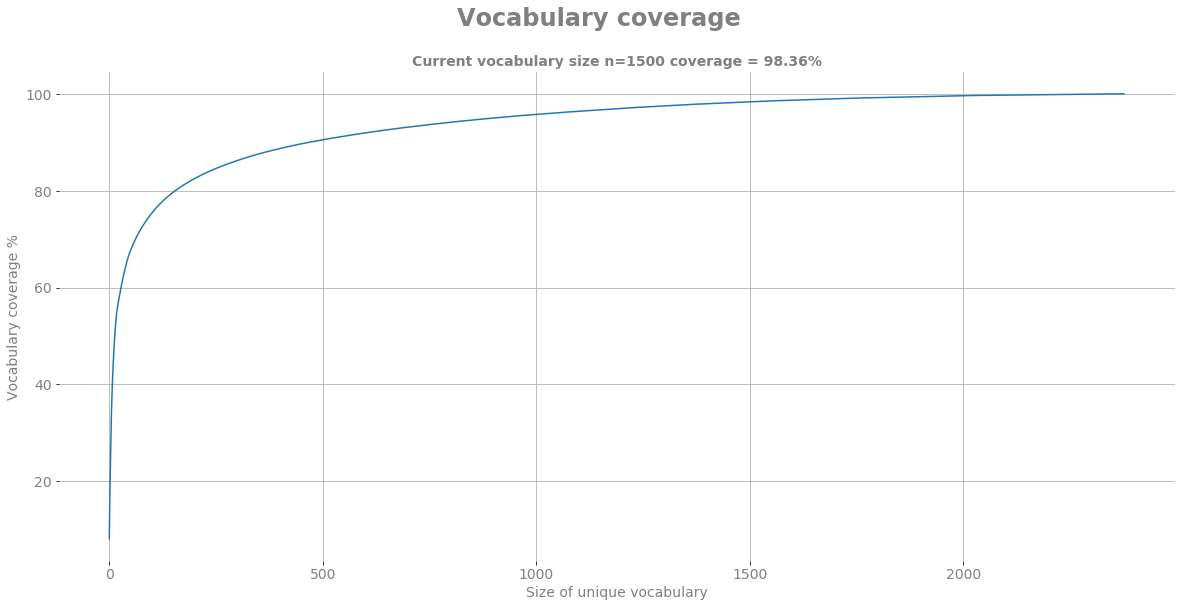

In [11]:
sick_dataset_train.plotVocabularyCoverage()

# Pretrained embeddings
https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  
For each word in dataset’s vocabulary, we check if it is on GloVe’s vocabulary. If it do it, we load its pre-trained word vector. Otherwise, we initialize a random vector.

In [12]:
EMBEDDINGS_SIZE = 50

In [13]:
from torchtext import vocab
#vocab is shared across all the text fields
#CAUTION: GloVe will download all embeddings locally (862 MB).
pretrained_emb = vocab.GloVe(name='6B', dim=EMBEDDINGS_SIZE)

# 0 is for the padding when using mini-batch (start at one, shift by one)
weights_matrix = np.zeros((vocabulary_size + 2, EMBEDDINGS_SIZE)) # do not forget the unk

found = 0
no_found = 0
# build a matrix of weights that will be loaded into the PyTorch embedding layer
for word_id in sick_dataset_train.dictionary:
    word = sick_dataset_train.dictionary[word_id]
    if word in pretrained_emb.stoi:
        pretrained_emb_ID = pretrained_emb.stoi[word]
        
        weights_matrix[word_id+1] = pretrained_emb.vectors[pretrained_emb_ID]
        found += 1
    else:
        weights_matrix[word_id+1] = np.random.normal(scale=0.6, size=(EMBEDDINGS_SIZE, ))
        no_found += 1
        
# UNK
weights_matrix[vocabulary_size+1] = np.random.normal(scale=0.6, size=(EMBEDDINGS_SIZE, ))

print(found, no_found)
        
pretrained_emb_vec = torch.tensor(weights_matrix, dtype=torch.float32)
print("Downloaded: Pretained Embedding matrix: " +  str(pretrained_emb.vectors.size()))
print("Adapted:    Pretained Embedding matrix: " +  str(pretrained_emb_vec.size()))

1398 102
Downloaded: Pretained Embedding matrix: torch.Size([400000, 50])
Adapted:    Pretained Embedding matrix: torch.Size([1502, 50])


In [14]:
print(sick_dataset_train.dictionary.doc2idx(["the", "The"]))
print(sick_dataset_train.dictionary[17])
print(pretrained_emb_vec[17+1])
# Glove dim=50 word=the vector[:4] = 0.418 0.24968 -0.41242 0.1217

[18, 24]
standing
tensor([-0.4088,  0.6761,  0.0735, -0.1806,  1.2443, -0.0917,  0.0386,  0.1979,
        -0.0458, -1.1083, -0.5975, -0.3853, -0.3361,  0.3328, -0.1278, -0.0295,
        -0.1130,  0.0644,  0.1915, -0.9226, -0.2098,  0.3553, -0.1223, -0.5348,
         0.4177, -1.4884,  0.2423,  0.5807, -0.2651,  0.1545,  2.7154,  0.3619,
         0.0442, -0.1549, -0.6539,  0.1046,  0.1774,  0.1194, -0.4762, -0.1801,
        -0.6075, -0.2769, -0.3217,  0.6482,  0.0115, -0.3640, -0.4810, -0.6800,
        -0.1294, -0.7417])


# To DataLoader

In [15]:
from torch.utils.data import DataLoader

In [16]:
def pad_collate(batch):
    seqs_labels = np.array(batch)[:,1]
    
    vectorized_seqs = np.array(batch)[:,0]
    seq_lengths = torch.LongTensor([len(x) for x in vectorized_seqs])
    
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
        
    vectorized_seqs = np.array(seq_tensor)
    
    return torch.tensor(vectorized_seqs), torch.LongTensor([ x for x in seqs_labels])


BATCH_SIZE = 8

train_loader = DataLoader(dataset=sick_dataset_train,
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

dev_loader = DataLoader(dataset=sick_dataset_dev,
                          batch_size=1, shuffle=False, collate_fn=pad_collate)

test_loader = DataLoader(dataset=sick_dataset_test,
                          batch_size=1, shuffle=False)

# Debug the padding
# display([ x for x in enumerate(train_loader)][0]) # has padding (sample of same size padded with 0)
# display([ x for x in enumerate(dev_loader)][0]) # no batch == no padding

# Evaluation helpers

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support

import itertools
import io
from tensorboardX.utils import figure_to_image
import matplotlib

def confusion_scores(total_labels, total_pred, writer=None):
    fig = plt.figure(figsize=(10,10))
    classes = SickDataset.text_label
    title='Confusion matrix'
    
    cm = confusion_matrix(total_labels, total_pred, labels=[0, 1, 2])
    
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, color='gray', fontsize=24)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [c.lower() for c in classes], rotation=45 , style='italic', color='gray', fontsize=17)
    plt.yticks(tick_marks, [c.lower() for c in classes], color='gray', style='italic', fontsize=17)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', color='gray', fontsize=19)
    plt.xlabel('Predicted label', color='gray', fontsize=19)
    plt.tight_layout()
    plt.show()
    if writer != None:
        writer.add_figure('plt/confusion_matrix', fig, 0)


def evaluate(model, loader, whileTraining=False, criterion=None, writer=None):
    """
    Displays the confusion_matrix the precision recall fscore
    If in whileTrainnig Mode only return the accuracy and loss
    """
    model.eval()
    with torch.no_grad():
        total_labels = torch.LongTensor([])
        total_pred = torch.LongTensor([])
        train_loss_batches = 0
        train_loss_batches_count = 0
        for batch_idx, (data, target) in enumerate(loader):

                data = data.to(device)
                target = target.to(device)

                output = rnn(data)
                
                if whileTraining and criterion != None:
                    loss = criterion(output, target)
                    train_loss_batches +=loss.cpu().detach().numpy()
                    train_loss_batches_count += 1

                # Get the Accuracy
                _, predicted = torch.max(output.data, dim=1)
                correct = (predicted == target).sum().item()
                
                total_labels = torch.cat((total_labels, target.cpu()))
                total_pred = torch.cat((total_pred, predicted.cpu()))
                
                
        model.train()
        if whileTraining and criterion!=None:
            return ((accuracy_score(total_labels.flatten().numpy(), total_pred.flatten().numpy()) * 100), train_loss_batches / train_loss_batches_count)

                
        confusion_scores(total_labels, total_pred, writer=writer)
        
        print("Accuracy:  {:.4f}".format(accuracy_score(total_labels, total_pred)))
        
        # compute per-label precisions, recalls, F1-scores, and supports instead of averaging 
        metrics = precision_recall_fscore_support(
                                        total_labels, total_pred,
                                        average=None, labels=[0, 1, 2])
        
        df = pd.DataFrame(list(metrics), index=['Precision', 'Recall', 'Fscore', 'support'],
                                   columns=SickDataset.text_label)
        df = df.drop(['support'], axis=0)
        display(df.T)
        


# Create the RNN Model

In [18]:
from torch import nn

In [19]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_voc_size, embedding_size, hidden_size):
        super(RNNClassifier, self).__init__()
        
        self.input_voc_size = input_voc_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.rnn_out_size = hidden_size * 2

        
        self.num_classes = 3
        
        # Add the padding token (0) (+1 to voc_size)
        # Pads the output with the embedding vector at padding_idx whenever it encounters the index..
        self.embedding = nn.Embedding(input_voc_size+1, embedding_size, padding_idx=0)
        # Load the pretrained embeddings
        # self.embedding.weight = nn.Parameter(pretrained_emb_vec) 
        # embeddings fine-tuning
        self.embedding.weight.requires_grad = False
        
        self.rnn = nn.GRU(
              input_size=embedding_size,
              hidden_size=hidden_size,
              batch_first=True,
              bidirectional=True,
        )
        
        self.fc1 = nn.Linear(self.rnn_out_size, self.num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    # input shape: B x S (input size)
    def forward(self, x):
        
        vprint("\nsize input", x.size())
        batch_size = x.size(0)
        
        # Initialize hidden (num_layers * num_directions, batch_size, hidden_size)
        h_0 = torch.zeros(2, batch_size, self.hidden_size)
        vprint("size hidden init", h_0.size())
        
        # When creating new variables inside a model (like the hidden state in an RNN/GRU/LSTM),
        # make sure to also move them to the device (GPU or CPU).
        h_0 = h_0.to(device)

        # Embedding B x S -> B x S x I (embedding size)
        emb = self.embedding(x)
        vprint("size Embedding", emb.size())
        
        # Propagate embedding through RNN
        # Input: (batch, seq_len, embedding_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(emb, h_0)
        
        vprint("size hidden", hidden.size())
        
        rnn_out = torch.cat((hidden[0], hidden[1]), 1)
        vprint("size rnn out", rnn_out.size())
        
        
        # Use the last layer output as FC's input
        layout_fc1 = self.fc1(rnn_out)
        vprint("size layout fc1", layout_fc1.size())
        
        fc_output = self.softmax(layout_fc1)
        
        return fc_output    
    
# Add the unknown token (+1 to voc_size)
rnn = RNNClassifier(vocabulary_size+1, EMBEDDINGS_SIZE, 20)
rnn.to(device)
print(rnn)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
weights = [1-((sick_dataset_train.df['entailment_id'] == i).sum() / len(sick_dataset_train)) for i in range(3)]
class_weights = torch.FloatTensor(weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

RNNClassifier(
  (embedding): Embedding(1502, 50, padding_idx=0)
  (rnn): GRU(50, 20, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=3, bias=True)
  (softmax): Softmax()
)


In [20]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [21]:
import os
import errno

def force_symlink(file1, file2):
    if os.path.exists(file2):
        os.remove(file2)
    os.symlink(file1, file2)

# Training the Model 

In [22]:
%%time
# Train the model

num_epochs=40

iter = 0
iter_batch = 0
best_accuracy_dev = 0.0

rnn.train()
for epoch in range(num_epochs):
    total_correct = 0
    total_target = 0
    train_loss_batches = 0
    train_loss_batches_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        output = rnn(data)
        
        vprint(output)
        loss = criterion(output, target)
        
        
        train_loss_batches += loss.cpu().detach().numpy()
        train_loss_batches_count += 1
        
        rnn.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Get the Accuracy
        _, predicted = torch.max(output.data, dim=1)
        correct = (predicted == target).sum().item()
        
        total_correct += correct
        total_target += target.size(0)
        
        if batch_idx % 200 == 0 or batch_idx % 200 == 1 or batch_idx == len(train_loader)-1:
            print('\rEpoch [{:3}/{}] | Step [{:5}/{} ({:3.0f}%)] | Loss {:.3f} | Accuracy {:.2f}%'.format(
                    epoch+1, num_epochs,
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item(), 
                    (total_correct / total_target) * 100), end=' ')
            
            writer.add_scalar('data/loss/_train_only', train_loss_batches / train_loss_batches_count, iter_batch)
            iter_batch += 1
            
        if Verbose:
            break
            
    accuracy_dev, loss_dev = evaluate(rnn, dev_loader, criterion=criterion, whileTraining=True)
    print("@ Loss_dev {:.3f} | Accuracy_dev {:.2f}%".format(loss_dev, accuracy_dev))
    
    if best_accuracy_dev < accuracy_dev:
        best_accuracy_dev = accuracy_dev
        file = 'checkpoint.pth.' + str(epoch) + '.acc.' + str(round(accuracy_dev,2)) + '.tar'
        torch.save({
            'epoch': epoch,
            'model_state_dict': rnn.state_dict(),
            'loss': loss,
            }, file)
        force_symlink(file, 'checkpoint.pth.best.tar')

    writer.add_scalars('data/loss/evol', {'train': train_loss_batches / train_loss_batches_count,
                                         'dev': loss_dev}, iter)
    iter += 1
            
            


print("Learning finished!")

Epoch [  1/40] | Step [ 2248/4500 (100%)] | Loss 1.116 | Accuracy 56.07% @ Loss_dev 0.985 | Accuracy_dev 56.00%
Epoch [  2/40] | Step [ 2248/4500 (100%)] | Loss 1.179 | Accuracy 56.53% @ Loss_dev 0.974 | Accuracy_dev 56.80%
Epoch [  3/40] | Step [ 2248/4500 (100%)] | Loss 0.988 | Accuracy 58.69% @ Loss_dev 0.928 | Accuracy_dev 59.40%
Epoch [  4/40] | Step [ 2248/4500 (100%)] | Loss 1.072 | Accuracy 59.69% @ Loss_dev 0.924 | Accuracy_dev 60.40%
Epoch [  5/40] | Step [ 2248/4500 (100%)] | Loss 0.748 | Accuracy 62.11% @ Loss_dev 0.925 | Accuracy_dev 60.40%
Epoch [  6/40] | Step [ 2248/4500 (100%)] | Loss 0.934 | Accuracy 63.80% @ Loss_dev 0.932 | Accuracy_dev 58.80%
Epoch [  7/40] | Step [ 2248/4500 (100%)] | Loss 1.198 | Accuracy 65.51% @ Loss_dev 0.951 | Accuracy_dev 56.80%
Epoch [  8/40] | Step [ 2248/4500 (100%)] | Loss 0.773 | Accuracy 66.31% @ Loss_dev 0.933 | Accuracy_dev 59.60%
Epoch [  9/40] | Step [ 2248/4500 (100%)] | Loss 0.829 | Accuracy 67.44% @ Loss_dev 0.940 | Accuracy_dev

# Evaluate the model on dev

In [23]:
checkpoint = torch.load('checkpoint.pth.best.tar')
rnn.load_state_dict(checkpoint['model_state_dict'])
print("=> loaded checkpoint epoch {}"
      .format(checkpoint['epoch']))

=> loaded checkpoint epoch 9


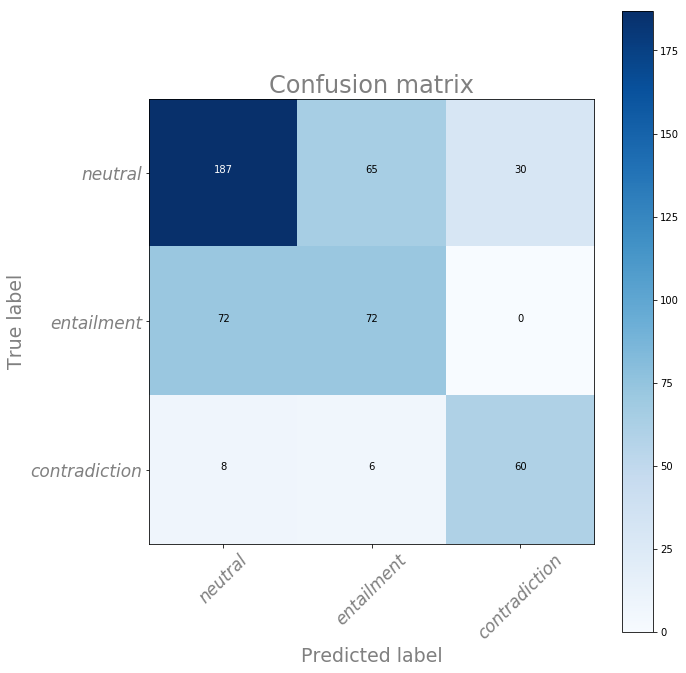

Accuracy:  0.6380


,Precision,Recall,Fscore
NEUTRAL,0.700375,0.663121,0.681239
ENTAILMENT,0.503497,0.500000,0.501742
CONTRADICTION,0.666667,0.810811,0.731707


CPU times: user 1.93 s, sys: 712 ms, total: 2.64 s
Wall time: 1.75 s


In [24]:
%%time

evaluate(rnn, dev_loader, writer=writer)

# Evaluate the model on test

In [25]:
%%time

# evaluate(rnn, test_loader)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
